In [1]:
import gw_ml_priors

In [2]:
import multiprocessing
import os
import shutil
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bilby.core.prior import Interped
from joblib import Parallel, delayed
from numpy.random import uniform as unif
from tqdm.auto import tqdm

from gw_ml_priors.conversions import calc_a2
from gw_ml_priors.regressors.scikit_regressor import ScikitRegressor

NUM_CORES = multiprocessing.cpu_count()


def get_a1_prior(xeff, q, mcmc_n=int(1e5)):
    a1s = np.linspace(0, 1, 500)
    da1 = a1s[1] - a1s[0]
    p_a1 = Parallel(n_jobs=NUM_CORES, verbose=1)(
        delayed(get_p_a1_given_xeff_q)(a1, xeff, q, mcmc_n)
        for a1 in tqdm(a1s, desc="Building a1 cache")
    )
    p_a1 = p_a1 / np.sum(p_a1) / da1
    data = pd.DataFrame(dict(a1=a1s, p_a1=p_a1))
    a1 = data.a1.values
    p_a1 = norm_values(data.p_a1.values, a1)
    min_b, max_b = find_boundary(a1, p_a1)
    return Interped(
        xx=a1, yy=p_a1, minimum=min_b, maximum=max_b, name="a_1", latex_label=r"$a_1$"
    )


def get_p_a1_given_xeff_q(a1, xeff, q, n=int(1e4)):
    cos1, cos2 = unif(-1, 1, n), unif(-1, 1, n)
    a2 = calc_a2(xeff=xeff, q=q, cos1=cos1, cos2=cos2, a1=a1)
    integrand = a2_interpreter_function(a2)
    return np.mean(integrand)


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def find_boundary_idx(x):
    """finds idx where data is non zero (assumes that there wont be gaps)"""
    non_z = np.nonzero(x)[0]
    return non_z[0], non_z[-1]


def norm_values(y, x):
    return y / np.trapz(y, x)


def find_boundary(x, y):
    b1, b2 = find_boundary_idx(y)
    vals = [x[b1], x[b2]]
    start, end = min(vals), max(vals)
    return start, end


def a2_interpreter_function(a2):
    return np.where(((0 < a2) & (a2 < 1)), 1, 0)




Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.39it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished


Text(0, 0.5, 'p(a1|q=0.5,xeff=-0.4)')

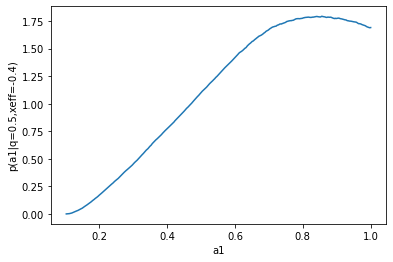

In [3]:

outdir = "out_p_a1_given_q_xeff"
os.makedirs(outdir, exist_ok=True)
q, xeff = 0.5, -0.4
a1_prior = get_a1_prior(q=q, xeff=xeff)
plt.plot(a1_prior.xx, a1_prior.yy)
plt.xlabel("a1")
plt.ylabel(f"p(a1|q={q},xeff={xeff})")

## TODO: train ML model to generate p(a1|xeff,q) for different q, xeff

In [4]:
a1_prior

Interped(xx=array([0.10220441, 0.1040036 , 0.10580279, 0.10760198, 0.10940117,
       0.11120036, 0.11299955, 0.11479874, 0.11659793, 0.11839711,
       0.1201963 , 0.12199549, 0.12379468, 0.12559387, 0.12739306,
       0.12919225, 0.13099144, 0.13279063, 0.13458982, 0.13638901,
       0.1381882 , 0.13998739, 0.14178658, 0.14358577, 0.14538496,
       0.14718415, 0.14898334, 0.15078253, 0.15258172, 0.15438091,
       0.1561801 , 0.15797929, 0.15977847, 0.16157766, 0.16337685,
       0.16517604, 0.16697523, 0.16877442, 0.17057361, 0.1723728 ,
       0.17417199, 0.17597118, 0.17777037, 0.17956956, 0.18136875,
       0.18316794, 0.18496713, 0.18676632, 0.18856551, 0.1903647 ,
       0.19216389, 0.19396308, 0.19576227, 0.19756146, 0.19936065,
       0.20115983, 0.20295902, 0.20475821, 0.2065574 , 0.20835659,
       0.21015578, 0.21195497, 0.21375416, 0.21555335, 0.21735254,
       0.21915173, 0.22095092, 0.22275011, 0.2245493 , 0.22634849,
       0.22814768, 0.22994687, 0.23174606, 0.23354

In [21]:
q_range = np.linspace(0, 1, 11)    # q range 0 to 1
xeff_range = np.linspace(-1, 1, 11)  # xeff range -1 to 1
print(q_range)
print(xeff_range)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]


### Generate data and save

In [22]:
data = []
for i in q_range:
    for j in xeff_range:
        print(f"q={i}, xeff={j}")
        a1_prior = get_a1_prior(q=i, xeff=j)
        plt.plot(a1_prior.xx, a1_prior.yy)
        plt.xlabel("a1")
        plt.ylabel(f"p(a1|q={i},xeff={j})")
        plt.savefig(f"{outdir}/p_a1_given_q_xeff_{i}_{j}.png")
        plt.close()
        # save to data
        data.append([i,j,a1_prior.xx,a1_prior.yy])
        



Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s]

q=0.0, xeff=-1.0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Building a1 cache: 100%|██████████| 500/500 [00:39<00:00, 12.58it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   41.1s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:45<00:00, 11.11it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   46.5s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:41<00:00, 11.94it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   43.4s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:41<00:00, 12.17it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.5s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:40<00:00, 12.21it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.4s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:41<00:00, 12.15it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.4s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:40<00:00, 12.21it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.4s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:41<00:00, 12.08it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.8s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:41<00:00, 12.13it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.8s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:41<00:00, 12.13it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.6s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.0, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:41<00:00, 12.10it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   42.7s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.51it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.0s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s]

q=0.1, xeff=-0.8


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.56it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.65it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.59it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.60it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:29<00:00, 16.82it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   30.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:29<00:00, 17.10it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   30.3s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.18it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.4s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.66it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.52it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.1, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.69it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.7s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.50it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.62it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.62it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.54it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.51it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.60it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.46it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.1s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.62it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.47it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.55it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.2, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.44it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.0s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.48it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.0s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.55it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.43it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.54it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.47it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:29<00:00, 17.06it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   30.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:28<00:00, 17.32it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   29.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.61it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.60it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.36it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.1s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.30000000000000004, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.61it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.46it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.20it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.5s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.68it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 17.95it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.07it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.37it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.2s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.39it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.06it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:28<00:00, 17.71it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   29.2s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:30<00:00, 16.64it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   31.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.4, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 17.95it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.8s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.39it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.1s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.44it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.09it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.22it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.3s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:28<00:00, 17.62it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   29.5s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:29<00:00, 17.14it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   30.1s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 17.97it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.77it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.5s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s]

q=0.5, xeff=0.6000000000000001


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.26it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.2s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 17.86it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.5, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.12it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.15it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.49it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.5s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.49it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.2s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.09it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.89it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.90it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.90it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.03it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.55it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.1s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.88it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.6000000000000001, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.78it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.1s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.89it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.31it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.4s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.22it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.5s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.96it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.94it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:26<00:00, 18.64it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   27.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.96it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.8s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.85it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.36it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.4s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.34it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.4s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.7000000000000001, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.85it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.89it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.28it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.4s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.3s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.94it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.31it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.5s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.78it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.1s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.51it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.2s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.96it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.46it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.3s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s]

q=0.8, xeff=0.8


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.81it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.1s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.8, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.09it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.05it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.8s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.80it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.1s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.24it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.13it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.21it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.68it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.2s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:27<00:00, 18.35it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   28.2s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.36it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.12it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.22it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=0.9, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.18it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=-1.0


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.05it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.8s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=-0.8


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.08it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=-0.6


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.11it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=-0.3999999999999999


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.19it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=-0.19999999999999996


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.24it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.5s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=0.0


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.13it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.7s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=0.20000000000000018


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.91it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.9s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=0.40000000000000013


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.22it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=0.6000000000000001


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.14it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=0.8


Building a1 cache: 100%|██████████| 500/500 [00:24<00:00, 20.18it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.6s finished
Building a1 cache:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


q=1.0, xeff=1.0


Building a1 cache: 100%|██████████| 500/500 [00:25<00:00, 19.89it/s]
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   26.0s finished
<ipython-input-2-aa2845171f48>:26: RuntimeWarning: invalid value encountered in true_divide
  p_a1 = p_a1 / np.sum(p_a1) / da1


In [23]:
df = pd.DataFrame(data)

In [24]:
df.columns = ["q","xeff","a1","p_a1"]

In [25]:
import pickle
# save the dataframe to pickle
with open(f"{outdir}/p_a1_given_q_xeff.pkl", "wb") as f:
    pickle.dump(df, f)

In [26]:
df

,q,xeff,a1,p_a1
0,0.0,-1.0,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,0.0,-0.8,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,0.0,-0.6,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,0.0,-0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,0.0,-0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...
116,1.0,0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[1.0680033419862862, 1.0678605941877117, 1.067..."
117,1.0,0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[0.7832345001188603, 0.7843442342552497, 0.784..."
118,1.0,0.6,"[0.2064128256513026, 0.2080031807101176, 0.209...","[0.0003581317510958827, 0.0006423405154926148,..."
119,1.0,0.8,"[0.6112224448897795, 0.6120015582266737, 0.612...","[0.003378646421929789, 0.004692188317429458, 0..."


Some data contains nans, remove them so that they won't cause problems later.

In [28]:
# test pickle file
out = pd.read_pickle(f"{outdir}/p_a1_given_q_xeff.pkl")

In [29]:
out

,q,xeff,a1,p_a1
0,0.0,-1.0,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,0.0,-0.8,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,0.0,-0.6,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,0.0,-0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,0.0,-0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...
116,1.0,0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[1.0680033419862862, 1.0678605941877117, 1.067..."
117,1.0,0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[0.7832345001188603, 0.7843442342552497, 0.784..."
118,1.0,0.6,"[0.2064128256513026, 0.2080031807101176, 0.209...","[0.0003581317510958827, 0.0006423405154926148,..."
119,1.0,0.8,"[0.6112224448897795, 0.6120015582266737, 0.612...","[0.003378646421929789, 0.004692188317429458, 0..."
